# Введение

В нашем распоряжении данные Яндекс.Афиши. В ходе работы рассчитаем следующие метрики: retention, LTV, CAC, ROMI. Определим саый прибыльный источник привлечения, а также устройство с которого зарабатываем. Таблицы содержат следующую инфрмацию:

<table>
  <tr>
    <th>visits</th>
    <th>orders</th>
    <th>costs</th>  
  </tr>
  <tr>
      <td><b>Uid</b> — уникальный идентификатор пользователя</td>
      <td><b>Uid</b> — уникальный id пользователя, который сделал заказ</td>
      <td><b>source_id</b> — идентификатор рекламного источника</td>
  </tr>
  <tr>
      <td><b>Device</b> — категория устройства пользователя</td>
      <td><b>Buy Ts</b> — дата и время заказа</td>
      <td><b>dt</b> — дата</td>
  </tr>
   <tr>
      <td><b>Start Ts</b> — дата и время начала сессии</td>
      <td><b>Revenue</b> — выручка Яндекс.Афиши с этого заказа</td>
      <td><b>costs</b> — затраты на этот рекламный источник в этот день</td>
  </tr>
    <tr>
      <td><b>End Ts</b> — дата и время окончания сессии</td>
  </tr>
        <tr>
            <td><b>Source Id</b> — идентификатор рекламного источника, из которого пришел пользователь</td>
  </tr>
</table>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from pandas.plotting import register_matplotlib_converters
import statistics
register_matplotlib_converters()
sns.set_style("darkgrid")

In [2]:
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_log.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_log.csv')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs.csv')

In [3]:
for i in [visits, orders, costs]:
    i.columns = i.columns.str.lower().str.replace(' ', '_')

In [4]:
def print_text(ax=None, text=None):
    text = ax.text(0.5, 0.5, text,
                ha='center', va='center', size=20)
    text.set_path_effects([path_effects.Normal()])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

# Продукт

In [5]:
visits = visits.assign(end_ts = pd.to_datetime(visits.end_ts),
                       start_ts = pd.to_datetime(visits.start_ts),
                       day = visits.start_ts.astype('datetime64[D]'),
                       week = visits.start_ts.astype('datetime64[W]'),
                       month = visits.start_ts.astype('datetime64[M]'),
                       year = visits.start_ts.astype('datetime64[Y]'))

## Сколько людей пользуются в день, неделю, месяц?

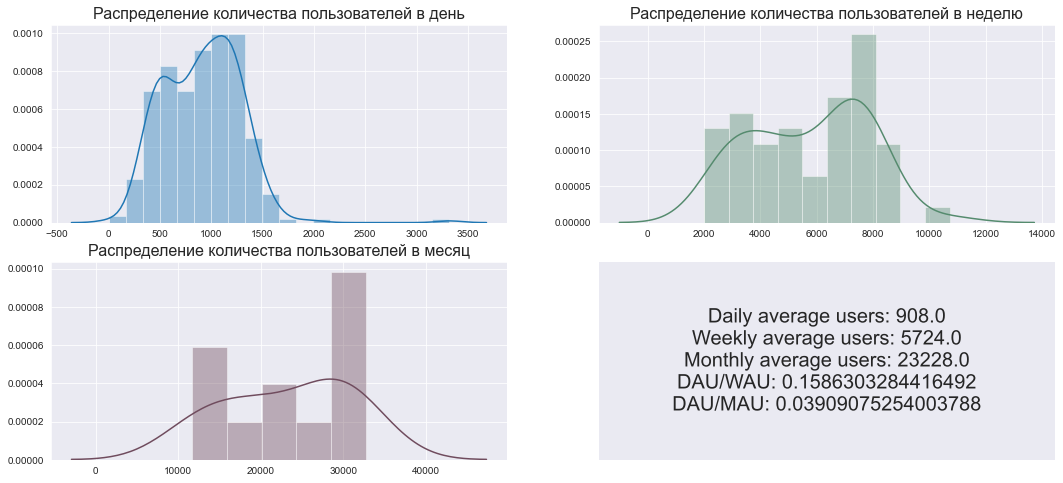

In [6]:
plt.figure(figsize=(18,8))
ax1 = plt.subplot(221)
sns.distplot(visits.groupby('day').agg({'uid' : 'nunique'}), bins=20)
ax1.set_title('Распределение количества пользователей в день', fontdict={'fontsize': 16})
dau = round(visits.groupby('day').agg({'uid' : 'nunique'}).mean().iloc[0])

ax2 = plt.subplot(222)
sns.distplot(visits.groupby('week').agg({'uid' : 'nunique'}), bins=10, color='#558B6E')
ax2.set_title('Распределение количества пользователей в неделю', fontdict={'fontsize': 16})
wau = round(visits.groupby('week').agg({'uid' : 'nunique'}).mean().iloc[0])

ax3 = plt.subplot(223)
sns.distplot(visits.groupby('month').agg({'uid' : 'nunique'}), bins=5, color='#704C5E')
ax3.set_title('Распределение количества пользователей в месяц', fontdict={'fontsize': 16})
mau = round(visits.groupby('month').agg({'uid' : 'nunique'}).mean().iloc[0])

ax4 = plt.subplot(224)
print_text(ax=ax4, text='''Daily average users: {}\nWeekly average users: {}\nMonthly average users: {}\nDAU/WAU: {}\nDAU/MAU: {}'''.format(dau, wau, mau, dau/wau, dau/mau))

## Сессия

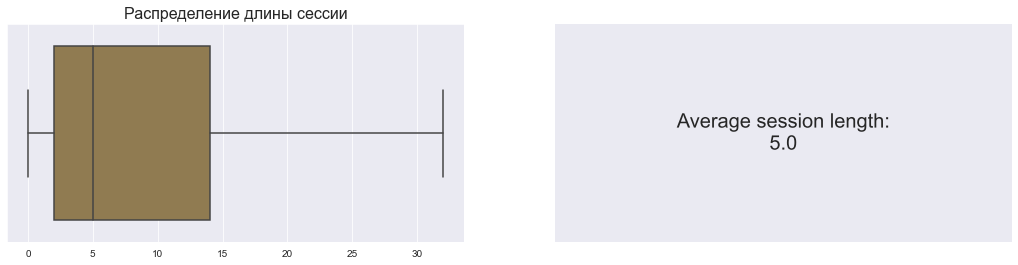

In [7]:
session_length = (visits.end_ts - visits.start_ts) / np.timedelta64(1,'m')

plt.figure(figsize=(18,4))
ax1 = plt.subplot(121)
sns.boxplot(data=session_length, orient='h', showfliers=False, color='#9B7E46')
ax1.set_title('Распределение длины сессии', fontdict={'fontsize': 16})
ax1.set_yticks([])

ax2 = plt.subplot(122)
print_text(ax=ax2, text='Average session length:\n{}'.format(session_length.median()))

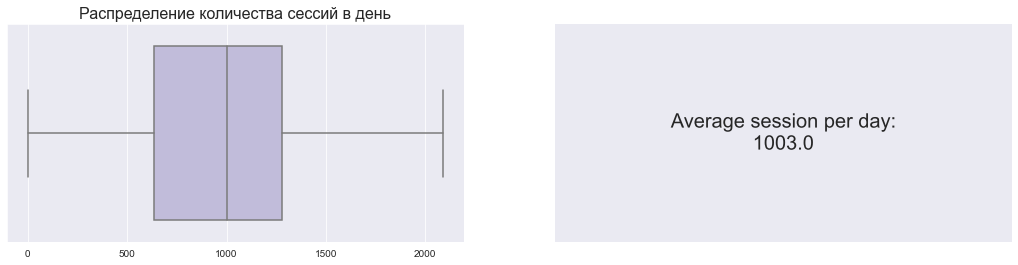

In [8]:
session_number = visits.groupby('day').agg({'start_ts' : 'count'}).reset_index()

plt.figure(figsize=(18,4))
ax1 = plt.subplot(121)
sns.boxplot(data=session_number.start_ts, orient='h', showfliers=False, color='#BEB7DF')
ax1.set_title('Распределение количества сессий в день', fontdict={'fontsize': 16})
ax1.set_yticks([])

ax2 = plt.subplot(122)
print_text(ax=ax2, text='Average session per day:\n{}'.format(session_number.median().iloc[0]))

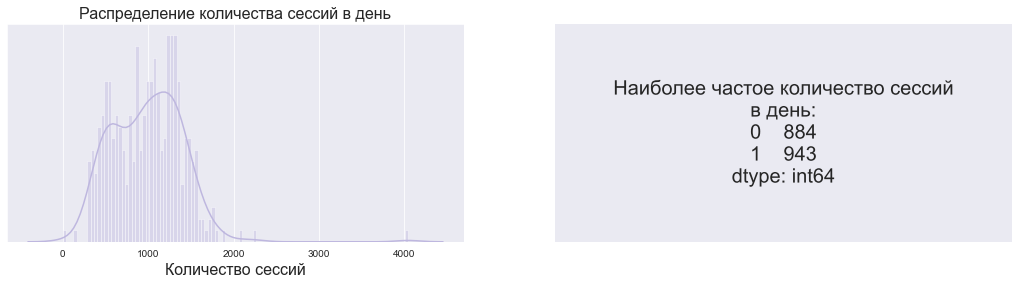

In [9]:
plt.figure(figsize=(18,4))
ax1 = plt.subplot(121)
sns.distplot(session_number.start_ts, color='#BEB7DF', bins=100)
ax1.set_title('Распределение количества сессий в день', fontdict={'fontsize': 16})
ax1.set_xlabel('Количество сессий', fontdict={'fontsize': 16})
ax1.set_yticks([])

ax2 = plt.subplot(122)
print_text(ax=ax2, text='Наиболее частое количество сессий\nв день:\n{}'.format(session_number.start_ts.mode()))

## Retention

In [10]:
# определяем когорты каждого посетителя (первый месяц посещения)
first_month = visits.groupby('uid').agg({'month' : 'min'}).reset_index()
first_month.columns = ['uid', 'cohort']
first_month

,uid,cohort
0,11863502262781,2018-03-01
1,49537067089222,2018-02-01
2,297729379853735,2017-06-01
3,313578113262317,2017-09-01
4,325320750514679,2017-09-01
...,...,...
228164,18446403737806311543,2017-11-01
228165,18446424184725333426,2017-12-01
228166,18446556406699109058,2018-01-01
228167,18446621818809592527,2017-12-01


In [11]:
# добавляем когорту в таблицу посетителей и посчитаем возраст последующих посещений
visits_cohorts = visits.merge(first_month, on='uid')
visits_cohorts['lifetime'] = ((visits_cohorts.month - visits_cohorts.cohort) / np.timedelta64(1,'M')).round().astype('int')
visits_cohorts

,device,end_ts,source_id,start_ts,uid,day,week,month,year,cohort,lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-08,2018-03-01,2018-01-01,2018-03-01,0
...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-23,2018-04-19,2018-04-01,2018-01-01,2018-04-01,0
359396,desktop,2017-11-08 13:39:00,4,2017-11-08 13:39:00,6761309174945977743,2017-11-08,2017-11-02,2017-11-01,2017-01-01,2017-11-01,0
359397,desktop,2017-07-31 12:31:00,3,2017-07-31 12:13:00,11102751930812818282,2017-07-31,2017-07-27,2017-07-01,2017-01-01,2017-07-01,0
359398,desktop,2018-03-20 15:25:00,4,2018-03-20 15:11:00,272012551460639309,2018-03-20,2018-03-15,2018-03-01,2018-01-01,2018-03-01,0


In [12]:
# формируем таблицу когорт
#cohorts = visits_cohorts.groupby(['cohort', 'lifetime', 'source_id', 'device']).agg({'uid':'nunique'}).reset_index()
cohorts = visits_cohorts.groupby(['cohort', 'lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,cohort,lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


In [13]:
#создадим датафррейм с количеством посетителей в начальный период
initial_users_count = cohorts[cohorts['lifetime'] == 0]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_visitors'})
initial_users_count

,cohort,lifetime,cohort_visitors
0,2017-06-01,0,13259
12,2017-07-01,0,13140
23,2017-08-01,0,10181
33,2017-09-01,0,16704
42,2017-10-01,0,25977
50,2017-11-01,0,27248
57,2017-12-01,0,25268
63,2018-01-01,0,22624
68,2018-02-01,0,22197
72,2018-03-01,0,20589


In [14]:
#добавим количество посетителей в нулевой месяц в основную таблицу
#cohorts = cohorts.merge(initial_users_count,on=['cohort', 'source_id', 'device'])
cohorts = cohorts.merge(initial_users_count,on=['cohort'])
cohorts = cohorts.drop('lifetime_y', axis=1)
cohorts = cohorts.rename(columns={'lifetime_x' : 'lifetime', 'uid' : 'visitors'})

In [15]:
cohorts

,cohort,lifetime,visitors,cohort_visitors
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


In [16]:
#считаем retention
cohorts['retention'] = cohorts['visitors'] / cohorts['cohort_visitors']

In [17]:
retention_pivot = cohorts.pivot_table(index='cohort',columns='lifetime',values='retention',aggfunc='mean')

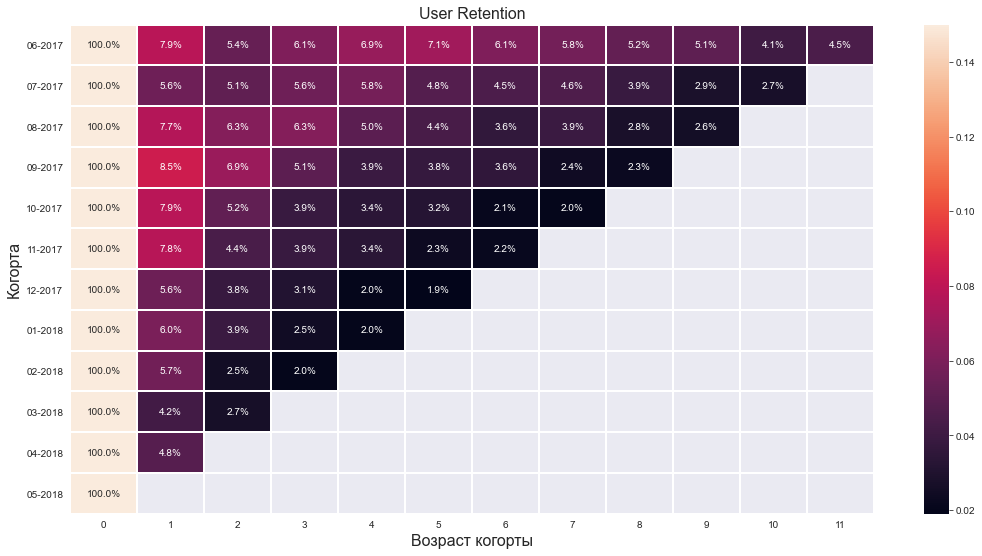

In [18]:
plt.figure(figsize=(18, 9))
ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, vmax=0.15)
ax.set_title('User Retention', fontdict={'fontsize': 16})
ax.set_xlabel('Возраст когорты', fontdict={'fontsize': 16})
ax.set_ylabel('Когорта', fontdict={'fontsize': 16})
ax.set_yticklabels(retention_pivot.index.strftime('%m-%Y'));

# Продажи

## Когда люди начинают покупать?

In [19]:
orders = orders.assign(buy_ts = pd.to_datetime(orders.buy_ts),
                       day = orders.buy_ts.astype('datetime64[D]'),
                       week = orders.buy_ts.astype('datetime64[W]'),
                       month = orders.buy_ts.astype('datetime64[M]'),
                       year = orders.buy_ts.astype('datetime64[Y]'))

In [20]:
first_ts = orders.groupby('uid').agg({'buy_ts' : 'min'}).reset_index()

first_buy = visits.groupby('uid').agg({'start_ts' : 'min'}).reset_index()

buy_start = first_buy.merge(first_ts, on='uid')

In [21]:
delta = ((buy_start.buy_ts - buy_start.start_ts) / np.timedelta64(1,'m')).astype('int')

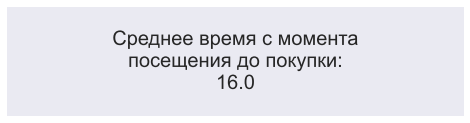

In [22]:
plt.figure(figsize=(18,2))
ax = plt.subplot(121)
print_text(ax=ax, text='Cреднее время с момента\nпосещения до покупки:\n{}'.format(delta.median()))

Ранее посчитали среднее время сессии, оно равнялось 5 минутам. Это значит что более половины пользоватлей не доходят до совершения покупки. Нужно уменьшать время от посещения до покупки. Оптимизировать процесс оплаты, сделав его более интуитивным.

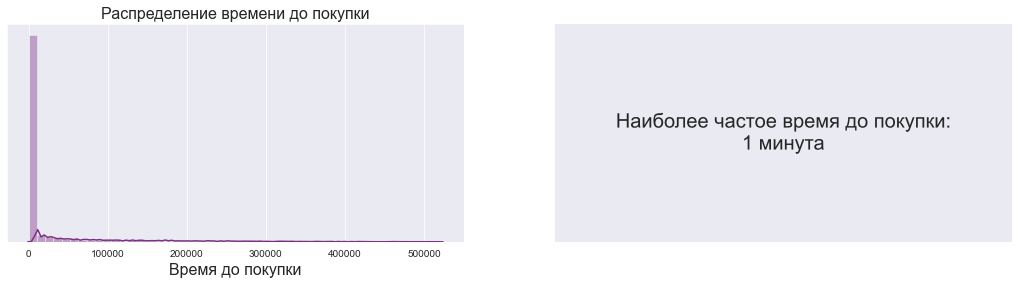

In [23]:
plt.figure(figsize=(18,4))
ax1 = plt.subplot(121)
sns.distplot(delta, color='#7E2E84')
ax1.set_title('Распределение времени до покупки', fontdict={'fontsize': 16})
ax1.set_xlabel('Время до покупки', fontdict={'fontsize': 16})
ax1.set_yticks([])

ax2 = plt.subplot(122)
print_text(ax=ax2, text='Наиболее частое время до покупки:\n{} минута'.format(delta.mode().iloc[0]))

## Сколько раз покупают за период?

In [24]:
number_of_buys = dict()
for i in ['day', 'week', 'month', 'year']:
    number_of_buys[i] = int(orders.groupby(i).agg({'uid' : 'nunique'})['uid'].mean())
number_of_buys = pd.DataFrame.from_dict(number_of_buys, orient='index').reset_index()
number_of_buys.columns = ['period', 'buys']
visitors = pd.Series([dau, wau, mau])
visitors.name = 'visitors'
number_of_buys = number_of_buys.join(visitors)
number_of_buys['converse'] = number_of_buys.visitors / number_of_buys.buys

In [25]:
number_of_buys

,period,buys,visitors,converse
0,day,127,908.0,7.149606
1,week,818,5724.0,6.997555
2,month,3155,23228.0,7.362282
3,year,19074,NaN,NaN


В среднем 7% процентов посетителей делают покупку. Далее конверсия булет посчитана точнее.

In [26]:
orders_by_month = orders.groupby('month').agg({'revenue' : 'sum', 'day' : 'count', 'uid' : 'nunique'}).reset_index()
orders_by_month['per_one_buyer'] = orders_by_month.day / orders_by_month.uid
orders_by_month = orders_by_month.drop(12)

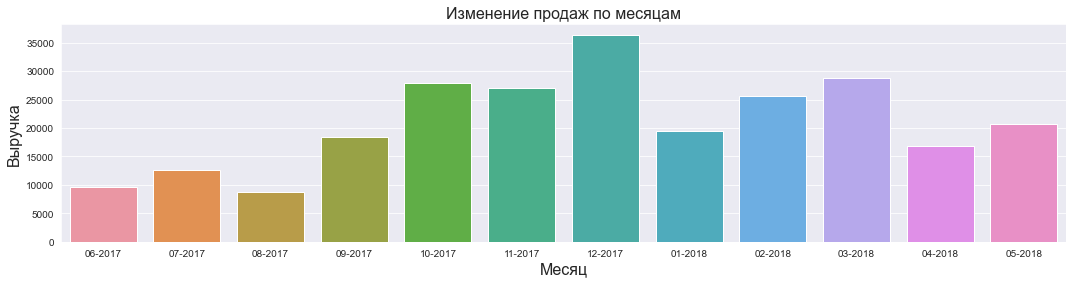

In [27]:
plt.figure(figsize=(18,4))
ax1 = sns.barplot(data=orders_by_month, x='month', y='revenue')
ax1.set_title('Изменение продаж по месяцам', fontdict={'fontsize': 16})
ax1.set_xlabel('Месяц', fontdict={'fontsize': 16})
ax1.set_ylabel('Выручка', fontdict={'fontsize': 16})
ax1.set_xticklabels(retention_pivot.index.strftime('%m-%Y'));

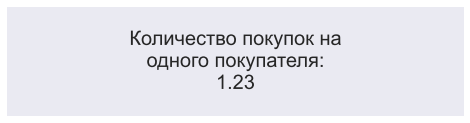

In [28]:
plt.figure(figsize=(18,2))
ax = plt.subplot(121)
print_text(ax=ax, text='Количество покупок на\nодного покупателя:\n{}'
           .format((orders_by_month.day.sum() / orders_by_month.uid.sum()).round(2)))

## Какой средний чек?

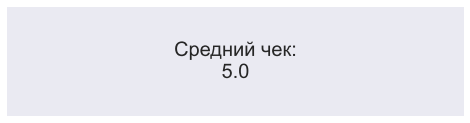

In [29]:
plt.figure(figsize=(18,2))
ax = plt.subplot(121)
print_text(ax=ax, text='Cредний чек:\n{}'.format(round(orders.revenue.mean(), 2)))

## LTV

In [30]:
#определим с какого источника и устройства покупатель пришел к нам в первый раз
first_visit_full = visits.loc[visits.groupby('uid')['month'].idxmin()]

In [31]:
#дополним информацию о покупателях источником, устройством и первым месяцем посещения
orders_add = orders.merge(first_visit_full[['device', 'source_id', 'uid']], on='uid')

In [32]:
#найдем первый месяц покупки пользователя и добавим его в таблицу
report_2 = orders_add.merge(orders_add
                        .groupby('uid')
                        .agg({'month' : 'min'})
                        .reset_index()
                        .rename(columns={'month' : 'first_order_month'}),
                        on = 'uid')

In [33]:
#считаем количество пользователей и выручку по источникам
report_2 = (report_2
            .groupby(['first_order_month', 'source_id', 'month'])
            .agg({'revenue' : 'sum' , 'uid' : 'nunique'})
            .reset_index())

In [34]:
#находим время жизни когорты
report_2['lifetime'] = ((report_2.month - report_2.first_order_month) / np.timedelta64(1,'M')).round().astype('int')

In [35]:
#находим первоначальное количество пользователей в источнике, добавляем в таблицу
report_2 = report_2.merge(report_2
                          .query('lifetime == 0')[['first_order_month', 'source_id', 'uid']]
                          .rename(columns={'uid' : 'n_buyers'}),
               on=['first_order_month', 'source_id'])

In [36]:
#находим выручку по когорте без источников
report_ltv = (report_2
              .groupby(['first_order_month', 'lifetime'])
              .agg({'revenue' : 'sum', 'n_buyers' : 'sum'})
              .reset_index()
              .drop(78))

In [37]:
#находим первоначальное количество пользователей в когорте без учета источников
report_ltv = report_ltv.merge(report_ltv.query('lifetime == 0')[['first_order_month', 'n_buyers']]
                         .rename(columns={'n_buyers' : 'n_0_buyers'}),
                         on = 'first_order_month')

In [38]:
#находим ltv по когорте
report_ltv['ltv'] = report_ltv['revenue'] / report_ltv['n_0_buyers']

In [39]:
ltv_pivot_2 = report_ltv.pivot_table(
        index='first_order_month', 
        columns='lifetime', 
        values='ltv', 
        aggfunc='mean').round(2)
ltv_pivot_2 = ltv_pivot_2.cumsum(axis=1).round(2)

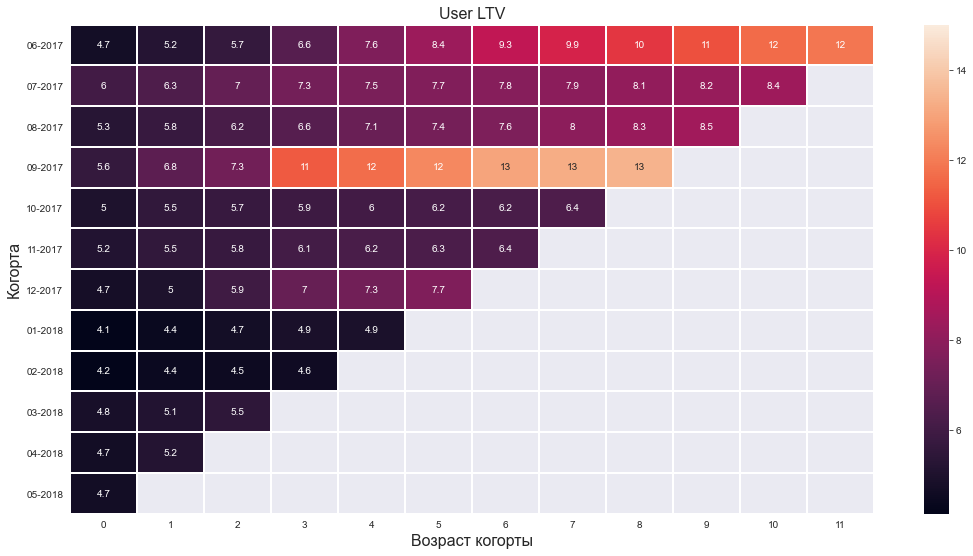

In [40]:
plt.figure(figsize=(18, 9))
ax = sns.heatmap(ltv_pivot_2, annot=True, linewidths=1, vmax=15)
ax.set_title('User LTV', fontdict={'fontsize': 16})
ax.set_xlabel('Возраст когорты', fontdict={'fontsize': 16})
ax.set_ylabel('Когорта', fontdict={'fontsize': 16})
ax.set_yticklabels(retention_pivot.index.strftime('%m-%Y'));

In [41]:
#считаем ltv по источникам
report_2['ltv'] = report_2['revenue'] / report_2['n_buyers']

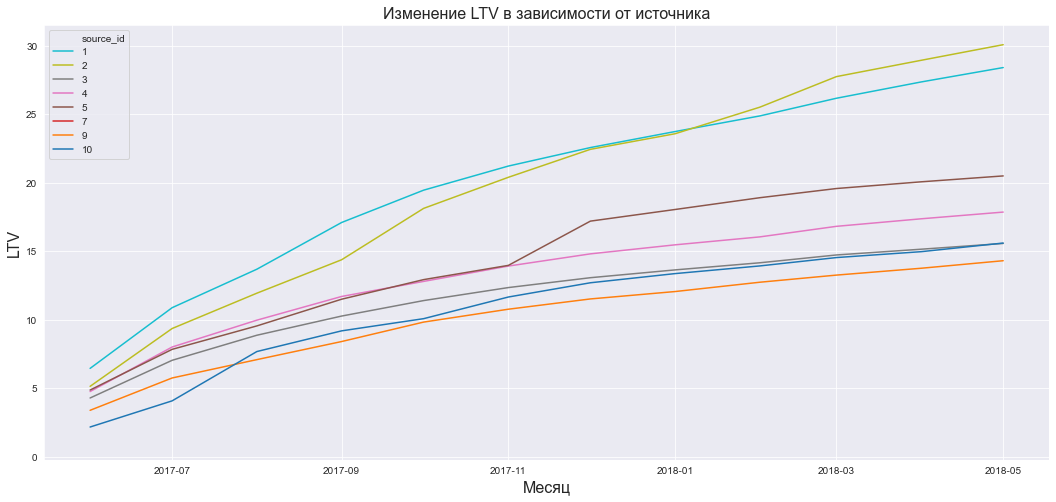

In [42]:
ltv_pivot_2 = report_2.pivot_table(
        index='source_id', 
        columns='month', 
        values='ltv', 
        aggfunc='mean').round(2)
ltv_pivot_2 = ltv_pivot_2.cumsum(axis=1).round(2)
ltv_in_time = pd.melt(ltv_pivot_2.reset_index(), id_vars=['source_id'])
plt.figure(figsize=(18, 8))
ax = sns.lineplot(data=ltv_in_time.query('month != "2018-06-01"'), 
             x='month', y='value', hue='source_id', palette='tab10_r', legend='full')
ax.set_title('Изменение LTV в зависимости от источника', fontdict={'fontsize': 16})
ax.set_xlabel('Месяц', fontdict={'fontsize': 16})
ax.set_ylabel('LTV', fontdict={'fontsize': 16});

# Маркетинг

## Сколько денег потратили?

In [43]:
costs = costs.assign(month = costs.dt.astype('datetime64[M]'))

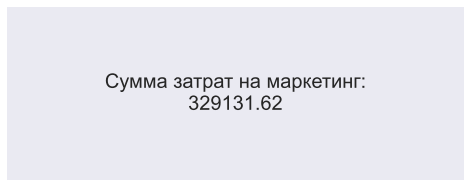

In [44]:
plt.figure(figsize=(18, 7))
ax = plt.subplot(221)
print_text(ax=ax, text='Сумма затрат на маркетинг:\n{}'.format(costs.costs.sum()))

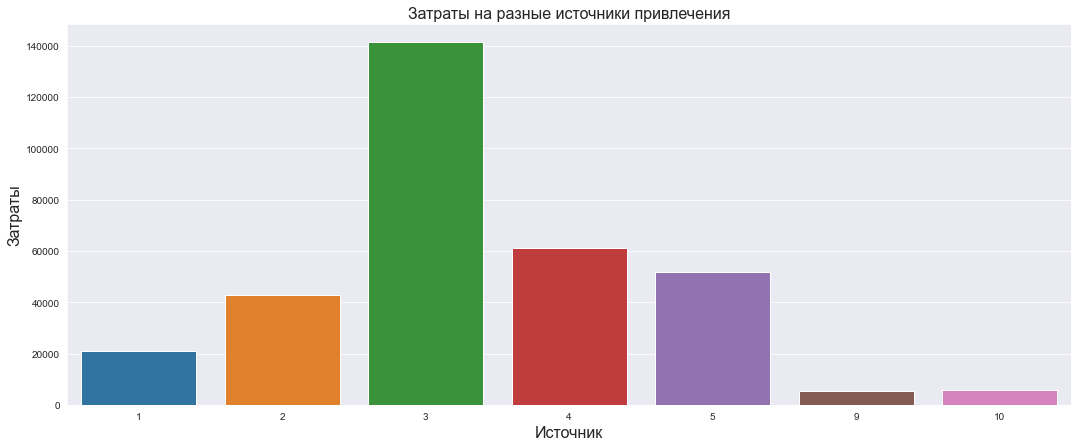

In [45]:
plt.figure(figsize=(18, 7))
ax = sns.barplot(data=costs.groupby('source_id').agg({'costs' : 'sum'}).reset_index(), x='source_id', y='costs')
ax.set_title('Затраты на разные источники привлечения', fontdict={'fontsize': 16})
ax.set_xlabel('Источник', fontdict={'fontsize': 16})
ax.set_ylabel('Затраты', fontdict={'fontsize': 16});

Источник под номером 3 оказался самым прожорливым. Хотя имеет посредственную конверсию. Далее оценим возврат инвестиций по всем источника. Скорее всего источник №3 окажется в числе аутсайдеров.

In [46]:
temp = costs.groupby(['month', 'source_id']).agg({'costs' : 'sum'}).reset_index()

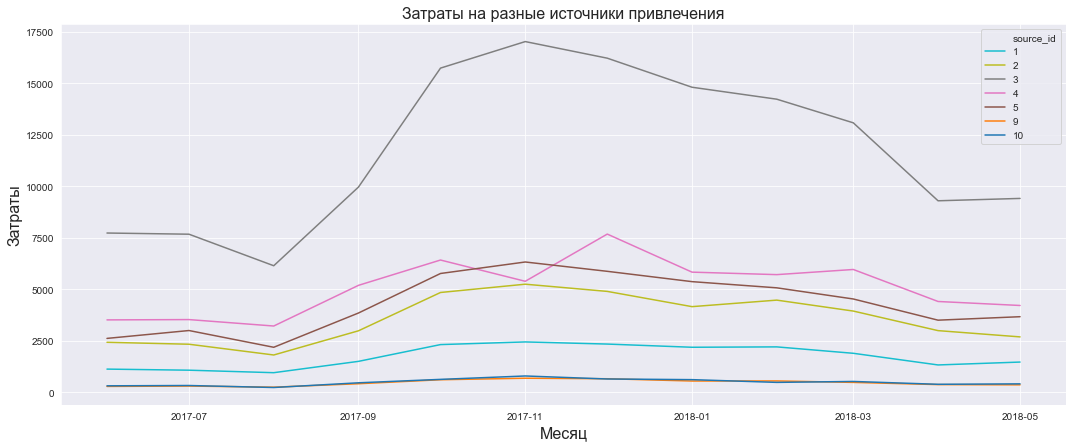

In [47]:
plt.figure(figsize=(18, 7))
ax = sns.lineplot(data=temp, x='month', y='costs', hue='source_id', legend='full', palette='tab10_r')
ax.set_title('Затраты на разные источники привлечения', fontdict={'fontsize': 16})
ax.set_xlabel('Месяц', fontdict={'fontsize': 16})
ax.set_ylabel('Затраты', fontdict={'fontsize': 16});

## Сколько стоило привлечение одного покупателя из каждого источника?

In [48]:
#найдем затраты по источникам на месяц
cost_by_month_source = costs.groupby(['source_id', 'month']).agg({'costs' : 'sum'}).reset_index()
cost_by_month_source = cost_by_month_source.rename(columns={'month' : 'cohort'})

In [49]:
cost_by_month_source = cost_by_month_source.merge(report_2, left_on = ['source_id', 'cohort'], 
                                                  right_on = ['source_id', 'first_order_month'])

In [50]:
cost_by_month_source = cost_by_month_source.drop('cohort', axis=1)

In [51]:
cost_by_month_source['cac'] = cost_by_month_source['costs'] / cost_by_month_source['n_buyers']

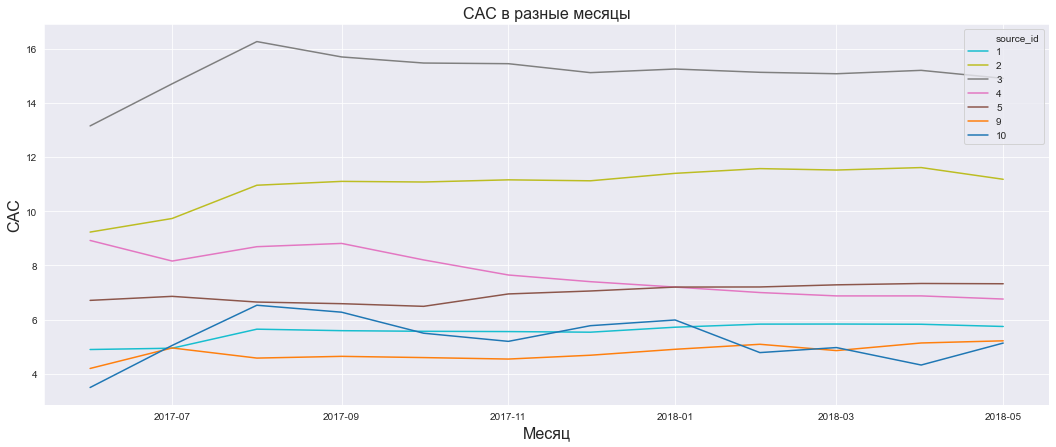

In [52]:
plt.figure(figsize=(18, 7))
ax = sns.lineplot(data=cost_by_month_source
                  .groupby(['month', 'source_id'])
                  .agg({'cac' : 'mean'})
                  .reset_index(), x='month', y='cac', hue='source_id', legend='full', palette='tab10_r')
ax.set_title('CAC в разные месяцы', fontdict={'fontsize': 16})
ax.set_xlabel('Месяц', fontdict={'fontsize': 16})
ax.set_ylabel('CAC', fontdict={'fontsize': 16});

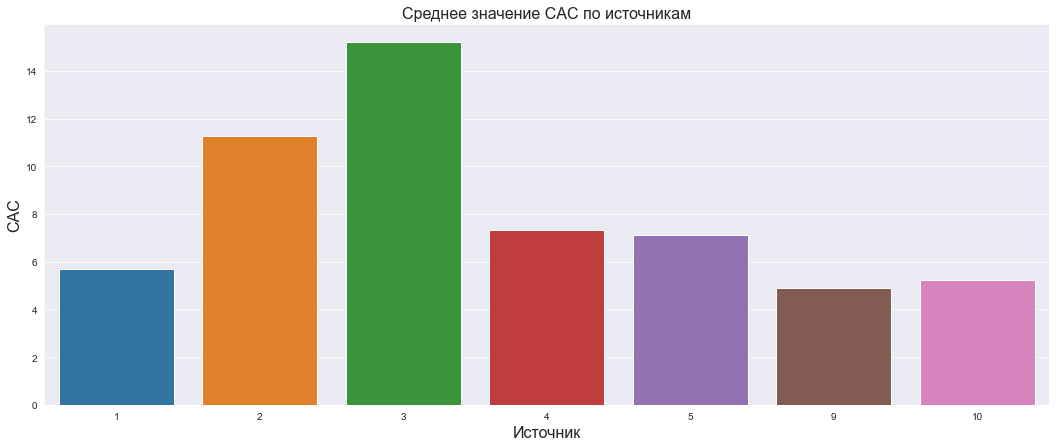

In [53]:
#найдем сколько стоило привлечение одного покупателя из каждого источника
plt.figure(figsize=(18, 7))
ax = sns.barplot(data=cost_by_month_source.groupby('source_id').agg({'cac' : 'mean'}).dropna().reset_index(),
                 x='source_id', y='cac')
ax.set_title('Среднее значение CAC по источникам', fontdict={'fontsize': 16})
ax.set_xlabel('Источник', fontdict={'fontsize': 16})
ax.set_ylabel('CAC', fontdict={'fontsize': 16});

In [54]:
cost_by_month_cohort = costs.groupby(['month']).agg({'costs' : 'sum'}).reset_index()
cost_by_month_cohort = cost_by_month_cohort.rename(columns={'month' : 'first_order_month'})

In [55]:
#добавим траты в сводную таблицу
cohort_ltv_cac = report_ltv.merge(cost_by_month_cohort, on=['first_order_month'], how='left')

In [56]:
#рассчитаем cac
cohort_ltv_cac['cac'] = cohort_ltv_cac['costs'] / cohort_ltv_cac['n_0_buyers']

## ROMI

In [57]:
cohort_ltv_cac['romi'] = cohort_ltv_cac['ltv'] / cohort_ltv_cac['cac']

In [58]:
romi_pivot = cohort_ltv_cac.pivot_table(
        index='first_order_month', 
        columns='lifetime', 
        values='romi', 
        aggfunc='mean')
romi_pivot = romi_pivot.cumsum(axis=1).round(2)

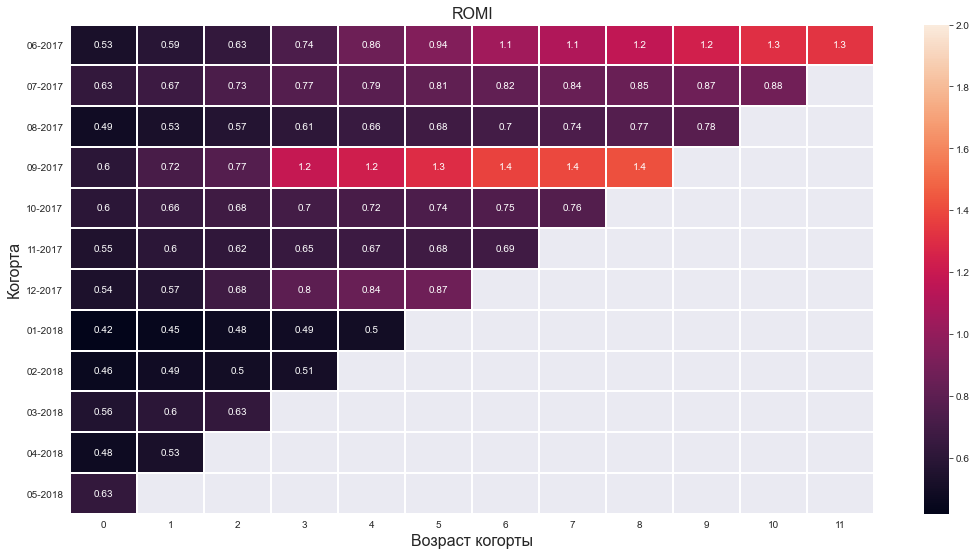

In [59]:
plt.figure(figsize=(18, 9))
ax = sns.heatmap(romi_pivot, annot=True, linewidths=1, vmax=2)
ax.set_title('ROMI', fontdict={'fontsize': 16})
ax.set_xlabel('Возраст когорты', fontdict={'fontsize': 16})
ax.set_ylabel('Когорта', fontdict={'fontsize': 16})
ax.set_yticklabels(romi_pivot.index.strftime('%m-%Y'));

In [60]:
romi_pivot_mean = cohort_ltv_cac.pivot_table(
        index='first_order_month', 
        columns='lifetime', 
        values='romi', 
        aggfunc='mean')

In [61]:
#рассчитаем среднее время окупаемости
romi_pivot_mean.cumsum(axis=1).mean(axis=0)

lifetime
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

In [62]:
cost_by_month_source['romi'] = cost_by_month_source['ltv'] / cost_by_month_source['cac']

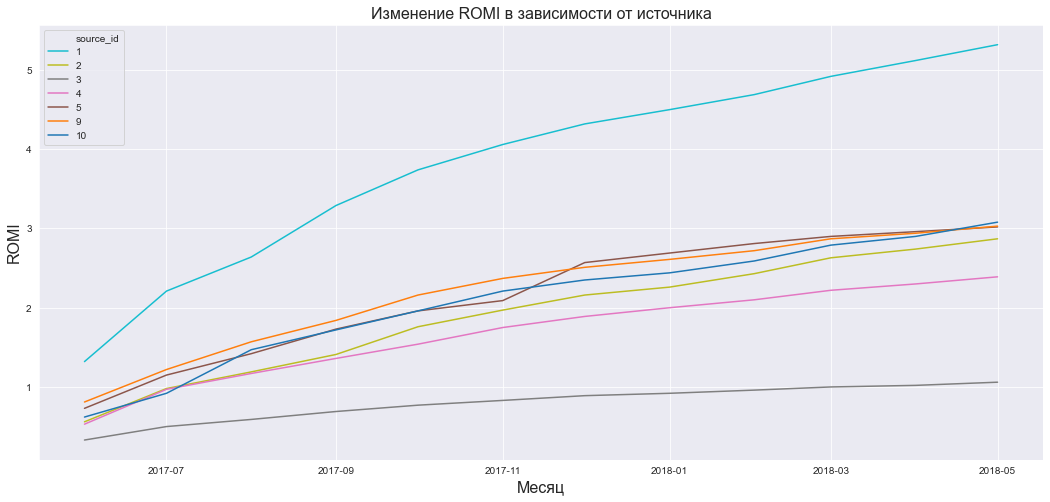

In [63]:
romi_pivot_2 = cost_by_month_source.pivot_table(
        index='source_id', 
        columns='month', 
        values='romi', 
        aggfunc='mean')
romi_pivot_2 = romi_pivot_2.cumsum(axis=1).round(2)
romi_in_time = pd.melt(romi_pivot_2.reset_index(), id_vars=['source_id'])
plt.figure(figsize=(18, 8))
ax = sns.lineplot(data=romi_in_time.query('month != "2018-06-01"'), 
             x='month', y='value', hue='source_id', palette='tab10_r', legend='full')
ax.set_title('Изменение ROMI в зависимости от источника', fontdict={'fontsize': 16})
ax.set_xlabel('Месяц', fontdict={'fontsize': 16})
ax.set_ylabel('ROMI', fontdict={'fontsize': 16});

# Отличие по источникам

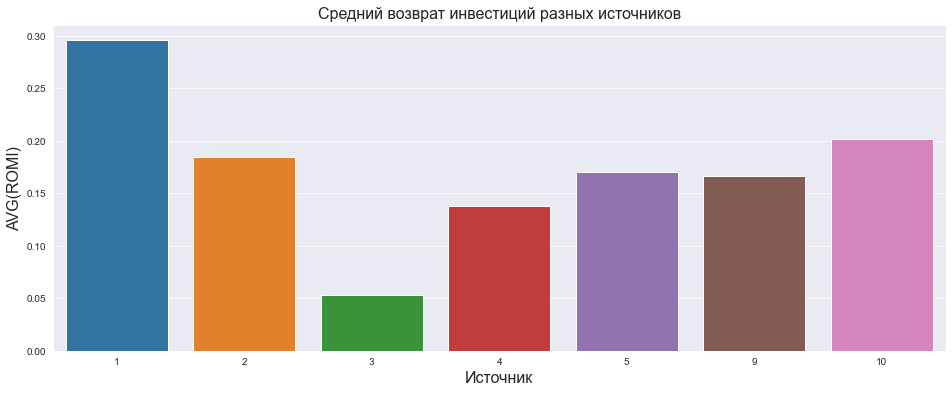

In [64]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=(cost_by_month_source
                  .groupby('source_id')
                  .agg({'romi' : 'mean'})
                  .dropna().sort_values(by='romi').reset_index()), x='source_id', y='romi')
ax.set_title('Средний возврат инвестиций разных источников', fontdict={'fontsize': 16})
ax.set_xlabel('Источник', fontdict={'fontsize': 16})
ax.set_ylabel('AVG(ROMI)', fontdict={'fontsize': 16});

Я считаю, что определяющей метрикой является возвращение инвестиций. Именно она показывает какие источники позволяют нам заработать. Наилучшим каналом привлечения денег оказался источник №1 на ПК. Худшим по затратам и конверсии оказался источник №3. Я бы предложил масштабировать привлечение клиентов через источник №1.